In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
# Baixa e extrai o dataset
! mkdir data
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

mkdir: cannot create directory ‘data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  2456k      0  0:00:04  0:00:04 --:--:-- 2550k
Archive:  data/animais.zip
replace data/animais/val/tatu/10242.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:46<00:00,  3.59s/it]


Epoch 1, Train Loss: 0.729, Train Accuracy: 50.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.458, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:43<00:00,  3.32s/it]


Epoch 2, Train Loss: 0.439, Train Accuracy: 82.75%
Epoch 2, Val Loss: 0.235, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:43<00:00,  3.38s/it]


Epoch 3, Train Loss: 0.326, Train Accuracy: 89.75%
Epoch 3, Val Loss: 0.165, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:42<00:00,  3.26s/it]


Epoch 4, Train Loss: 0.303, Train Accuracy: 87.00%
Epoch 4, Val Loss: 0.143, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:42<00:00,  3.28s/it]


Epoch 5, Train Loss: 0.297, Train Accuracy: 88.00%
Epoch 5, Val Loss: 0.147, Val Accuracy: 95.90%
Treinamento concluído


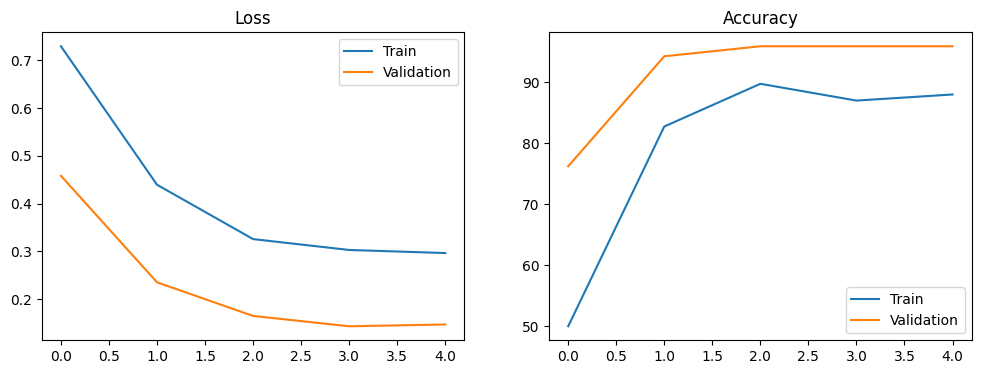

In [ ]:
plot_history(history)

In [ ]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 95.90%


In [ ]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

In [ ]:
# Carregando o dataset sem data augmentation
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)

In [ ]:
# Reinicializando o modelo
model_no_aug = models.resnet18(weights="IMAGENET1K_V1")


In [ ]:
# Congelar todas as camadas
for param in model_no_aug.parameters():
    param.requires_grad = False


In [ ]:
# Substituir a última camada
model_no_aug.fc = nn.Linear(model_no_aug.fc.in_features, 2)
model_no_aug = model_no_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_no_aug.parameters(), lr=0.001, momentum=0.9)


In [ ]:
# Treinando a CNN sem data augmentation
history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion, optimizer, device, num_epochs=5)


100%|██████████| 13/13 [00:43<00:00,  3.32s/it]


Epoch 1, Train Loss: 0.573, Train Accuracy: 67.75%
Epoch 1, Val Loss: 0.454, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:42<00:00,  3.24s/it]


Epoch 2, Train Loss: 0.328, Train Accuracy: 90.25%
Epoch 2, Val Loss: 0.257, Val Accuracy: 87.70%


100%|██████████| 13/13 [00:41<00:00,  3.23s/it]


Epoch 3, Train Loss: 0.241, Train Accuracy: 94.00%
Epoch 3, Val Loss: 0.200, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:43<00:00,  3.32s/it]


Epoch 4, Train Loss: 0.206, Train Accuracy: 93.75%
Epoch 4, Val Loss: 0.179, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:46<00:00,  3.56s/it]


Epoch 5, Train Loss: 0.190, Train Accuracy: 95.00%
Epoch 5, Val Loss: 0.180, Val Accuracy: 91.80%
Treinamento concluído


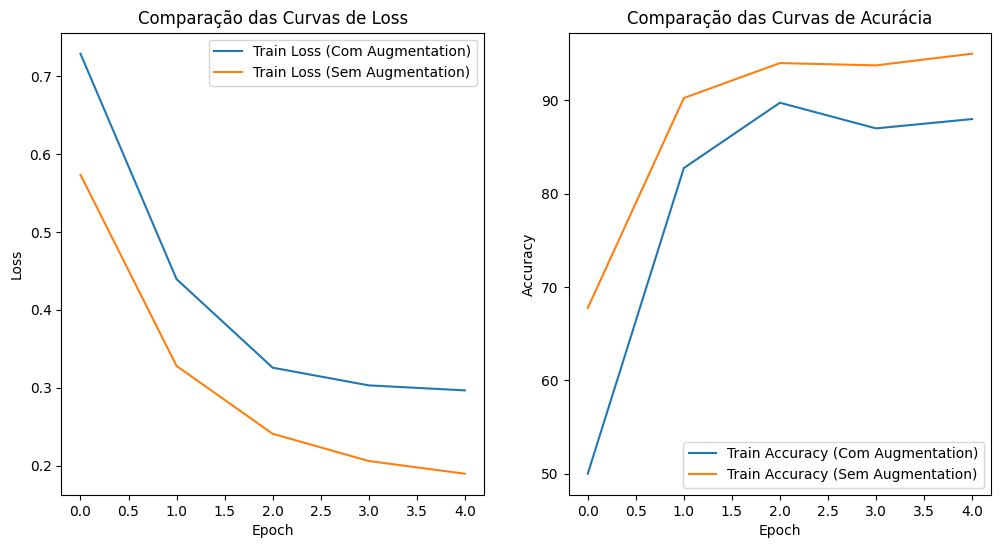

In [ ]:
# Plotando as curvas de treinamento e validação para comparação
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss (Com Augmentation)')
plt.plot(history_no_aug['train_losses'], label='Train Loss (Sem Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparação das Curvas de Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracies'], label='Train Accuracy (Com Augmentation)')
plt.plot(history_no_aug['train_accuracies'], label='Train Accuracy (Sem Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparação das Curvas de Acurácia')

plt.show()

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [ ]:
# Descongelar algumas das últimas camadas
for name, param in model.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True


In [ ]:
# Configurando o otimizador para treinar as camadas descongeladas
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)


In [ ]:
# Treinando o modelo com as camadas descongeladas
history_unfreeze = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)


100%|██████████| 13/13 [00:59<00:00,  4.54s/it]


Epoch 1, Train Loss: 0.263, Train Accuracy: 90.00%
Epoch 1, Val Loss: 0.125, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:57<00:00,  4.40s/it]


Epoch 2, Train Loss: 0.245, Train Accuracy: 92.25%
Epoch 2, Val Loss: 0.123, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:57<00:00,  4.45s/it]


Epoch 3, Train Loss: 0.241, Train Accuracy: 90.75%
Epoch 3, Val Loss: 0.113, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:56<00:00,  4.37s/it]


Epoch 4, Train Loss: 0.175, Train Accuracy: 94.00%
Epoch 4, Val Loss: 0.095, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:57<00:00,  4.44s/it]


Epoch 5, Train Loss: 0.181, Train Accuracy: 93.75%
Epoch 5, Val Loss: 0.099, Val Accuracy: 95.90%
Treinamento concluído


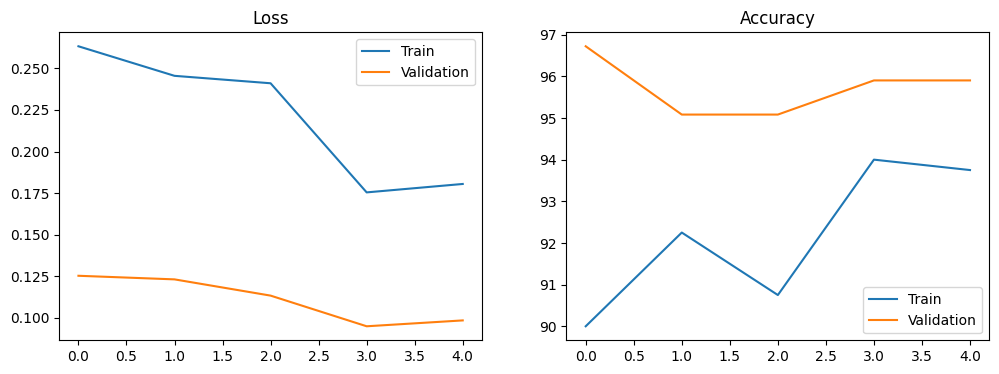

In [ ]:
# Comparando as curvas de treinamento e validação
plot_history(history_unfreeze)

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [ ]:
# Usando o modelo VGG16 pré-treinado
model_vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 56.6MB/s]


In [ ]:
# Congelar todas as camadas
for param in model_vgg16.parameters():
    param.requires_grad = False



In [ ]:
# Substituir a última camada totalmente conectada
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, 2)
model_vgg16 = model_vgg16.to(device)


In [ ]:
# Configurando o otimizador
optimizer = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)


In [ ]:
# Treinando o modelo VGG16
history_vgg16 = train_model(model_vgg16, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)


100%|██████████| 13/13 [04:39<00:00, 21.46s/it]


Epoch 1, Train Loss: 0.465, Train Accuracy: 75.75%
Epoch 1, Val Loss: 0.171, Val Accuracy: 94.26%


100%|██████████| 13/13 [04:33<00:00, 21.03s/it]


Epoch 2, Train Loss: 0.252, Train Accuracy: 88.75%
Epoch 2, Val Loss: 0.132, Val Accuracy: 94.26%


100%|██████████| 13/13 [04:42<00:00, 21.70s/it]


Epoch 3, Train Loss: 0.209, Train Accuracy: 92.00%
Epoch 3, Val Loss: 0.128, Val Accuracy: 94.26%


100%|██████████| 13/13 [04:34<00:00, 21.13s/it]


Epoch 4, Train Loss: 0.224, Train Accuracy: 89.75%
Epoch 4, Val Loss: 0.131, Val Accuracy: 94.26%


100%|██████████| 13/13 [04:43<00:00, 21.84s/it]


Epoch 5, Train Loss: 0.195, Train Accuracy: 92.25%
Epoch 5, Val Loss: 0.120, Val Accuracy: 95.90%
Treinamento concluído


In [ ]:
# Teste do modelo VGG16
test_model(model_vgg16, val_loader)